In [1]:
import pandas as pd
import streamlit as st

import pymysql
from streamlit_echarts import st_echarts
import empyrical
from easyquotation import use
from langchain.callbacks.base import BaseCallbackHandler
from langchain.schema import ChatMessage
from langchain_openai import ChatOpenAI

In [31]:
openai_api_key = "sk-ggG8JABUn8YagGna1b5d6374Aa7e425e9543Db925f0f270a"
openai_base_url = "http://192.210.174.111:3000/v1"

In [51]:
llm = ChatOpenAI(openai_api_key=openai_api_key,
                base_url=openai_base_url, 
                model="ERNIE-Speed-8K",
                streaming=True
                )

In [52]:
response = llm.stream("介绍下百度")

In [53]:
for ele in response:
    print(ele.content)

百度是中国
最大的互联网搜索引擎和技术公司之一，成立于1999年，总部设在中国北京。
除了搜索引擎，百度还提供一系列其他的互联网服务和产品，如在线广告、移动应用、云计算等。
百度是全球最大的中文搜索引擎之一，每天响应来自数十亿次的搜索请求。
除了中文搜索服务外，百度还提供了多种语言版本的搜索服务。
百度致力于为用户提供更准确、更全面的搜索结果和更好的用户体验。
除了搜索服务外，百度还推出了许多其他产品和服务，如百度地图、百度文库等。
此外，百度还致力于人工智能技术的研发和应用，如语音识别、自然语言处理等领域。
总之，百度是一家综合性互联网公司，拥有强大的技术实力和丰富的产品线，致力于为用户提供更好的互联网服务和体验。



In [1]:
from src.qtrade.mysql_util import *
import numpy as np
import pandas as pd
import math

m_days = 25

In [53]:
codes = ['518880', # 黄金ETF
         '159941', #纳指
         '159915', #创业板
         '510180'  #红利
         ]

with get_connection() as cursor:
    sql = f'''
    select code, date, close
    from etf.ods_etf_history
    where code in {tuple(codes)} and date>='2019-01-18'
    order by code, date
    '''
    cursor.execute(sql)
    data = cursor.fetchall()

In [54]:
df = pd.DataFrame(data, columns=['code','date','close'])

In [55]:
df.tail()

,code,date,close
5178,518880,2024-05-21,5.481
5179,518880,2024-05-22,5.492
5180,518880,2024-05-23,5.366
5181,518880,2024-05-24,5.319
5182,518880,2024-05-27,5.338


In [56]:
data_dict = {}
id2date_dict = {}
for ele in codes:
    sigle_df = df[df.code==ele]
    sigle_df.index = range(len(sigle_df))
    data_dict[ele] = sigle_df

In [57]:
df.groupby("code").count()

,date,close
code,,
159915,1295,1295
159941,1296,1296
510180,1296,1296
518880,1296,1296


In [58]:
dates = df.date.unique().tolist()

In [59]:
dates = sorted(dates)

In [60]:
id2date_dict = dict(zip(range(len(dates)), dates))

In [61]:
def get_history_data(code, index, m_days):
    ele = data_dict[code]
    select_df = ele.iloc[(index+1-m_days):index+1]
    return select_df

In [62]:
data_dict["518880"].shape

(1296, 3)

In [64]:
score_list = []

for etf in codes:
    df = get_history_data(etf, 1307, 25)
    y = np.log(df.close)
    x = df['num'] = np.arange(y.size)
    slope, intercept = np.polyfit(x, y, 1)
    annualized_returns = math.pow(math.exp(slope), 250) - 1
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    score = annualized_returns * r_squared
    score_list.append(score)

C:\Users\xiaolei.zuo\AppData\Local\Temp\ipykernel_21112\2639169113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x = df['num'] = np.arange(y.size)
C:\Users\xiaolei.zuo\AppData\Local\Temp\ipykernel_21112\2639169113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x = df['num'] = np.arange(y.size)
C:\Users\xiaolei.zuo\AppData\Local\Temp\ipykernel_21112\2639169113.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [66]:
codes[np.argmax(score_list)]

'159941'

In [67]:
def get_current_best_code(num=1307):
    score_list = []

    for etf in codes:
        df = get_history_data(etf, num, m_days)
        y = np.log(df.close)
        x = df['num'] = np.arange(y.size)
        slope, intercept = np.polyfit(x, y, 1)
        annualized_returns = math.pow(math.exp(slope), 250) - 1
        r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
        score = annualized_returns * r_squared
        score_list.append(score)
    return codes[np.argmax(score_list)]

In [68]:
from tqdm import tqdm

In [69]:
len(dates)

1296

In [70]:
codes

['518880', '159941', '159915', '510180']

In [71]:
data_dict[ele].head()

,code,date,close
0,510180,2019-01-18,8.254
1,510180,2019-01-21,8.277
2,510180,2019-01-22,8.194
3,510180,2019-01-23,8.179
4,510180,2019-01-24,8.232


In [98]:
result = []
last_status = "empty"
last_stock = None
last_profit = 1
for num in tqdm(range(25, len(dates)-1)):
    best_code = get_current_best_code(num)
    date = dates[num]
    if last_status == "empty":
        last_status = "buy"
        result.append([date, last_profit, best_code, last_status])
        last_stock = best_code
    else:
        last_profit = last_profit*(data_dict[last_stock].loc[num, 'close']/data_dict[last_stock].loc[num-1, 'close'])
        last_status = 'hold' if last_stock==best_code else 'buy'
        result.append([date, last_profit, best_code, last_status])
        last_stock = best_code

  0%|          | 0/1270 [00:00<?, ?it/s]C:\Users\xiaolei.zuo\AppData\Local\Temp\ipykernel_21112\3120098255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x = df['num'] = np.arange(y.size)
C:\Users\xiaolei.zuo\AppData\Local\Temp\ipykernel_21112\3120098255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x = df['num'] = np.arange(y.size)
C:\Users\xiaolei.zuo\AppData\Local\Temp\ipykernel_21112\3120098255.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [99]:
result[-10:]

[['2024-05-13', 3.240508910394926, '159915', 'hold'],
 ['2024-05-14', 3.2119109277328635, '159915', 'hold'],
 ['2024-05-15', 3.2190604233983793, '159915', 'hold'],
 ['2024-05-16', 3.260170023475094, '159915', 'hold'],
 ['2024-05-17', 3.2726816408897457, '159915', 'hold'],
 ['2024-05-20', 3.24944577997682, '159915', 'hold'],
 ['2024-05-21', 3.2869806322207764, '159915', 'hold'],
 ['2024-05-22', 3.2369341625621675, '159941', 'buy'],
 ['2024-05-23', 3.2651906198493257, '159941', 'hold'],
 ['2024-05-24', 3.20867770527501, '159941', 'hold']]

In [100]:
result = pd.DataFrame(result, columns=['date', 'profit', 'code', 'status'])

In [101]:
result.tail()

,date,profit,code,status
1265,2024-05-20,3.249446,159915,hold
1266,2024-05-21,3.286981,159915,hold
1267,2024-05-22,3.236934,159941,buy
1268,2024-05-23,3.265191,159941,hold
1269,2024-05-24,3.208678,159941,hold


In [102]:
result['ma5'] = result['profit'].rolling(window=5).mean()

In [103]:
import matplotlib.pyplot as plt

In [117]:
x = pd.to_datetime(result['date'].tail(100))
y1 = result['profit'].tail(100)
y2 = result['ma5'].tail(100)

<Axes: >

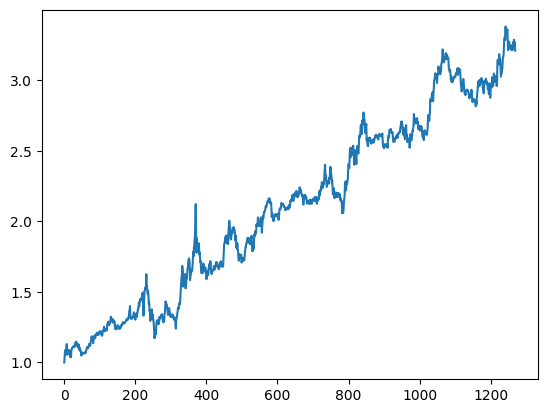

In [116]:
result['profit'].plot()

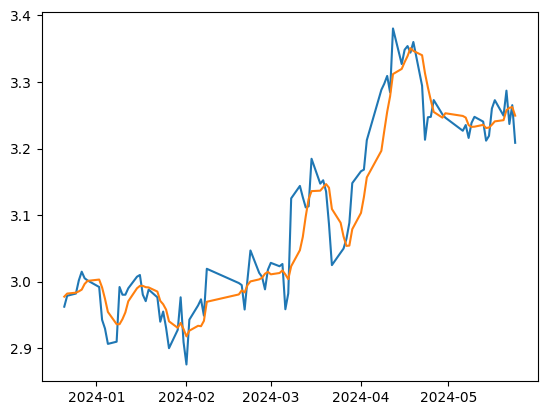

In [118]:
plt.plot(x, y1)
plt.plot(x, y2)

In [77]:
import empyrical

In [78]:
def calc_indicators(df_returns):
    accu_returns = empyrical.cum_returns_final(df_returns)
    annu_returns = empyrical.annual_return(df_returns)
    max_drawdown = empyrical.max_drawdown(df_returns)
    sharpe = empyrical.sharpe_ratio(df_returns)
    return accu_returns, annu_returns, max_drawdown, sharpe

In [79]:
result.index = pd.to_datetime(result['date'])
result["profit"] = result["profit"] / result["profit"].shift() - 1
accu_returns, annu_returns, max_drawdown, sharpe = calc_indicators(result['profit'])

In [80]:
accu_returns, annu_returns, max_drawdown, sharpe

(2.20867770527501, 0.2602823538144827, -0.2789739500265812, 1.1113338021915684)

In [119]:
import numpy as np


def hurst(X):
    
    #输入日回报率
    X = np.array(X)
    
    #N代表最大的片段值（即不对X分割时）
    N = X.size
    
    T = np.arange(1, N + 1)
    Y = np.cumsum(X)
    
    #分别计算不同长度的片段的均值
    Ave_T = Y / T

    #每个片段的最大差距R_T
    R_T = np.zeros(N)
    #对应的每段的标准差S_T
    S_T = np.zeros(N)
    
    #分别对不同的大小的切片计算R_T和S_T
    for i in range(N):
        S_T[i] = np.std(X[:i + 1])
        Z_T = Y - T * Ave_T[i]
        R_T[i] = np.ptp(Z_T[:i + 1])
        
    #计算R/S
    R_S = R_T / S_T
    
    #将lg(R/S)作为被解释变量Y
    R_S = np.log(R_S)[1:]
    
    #将lgt作为解释变量X
    n = np.log(T)[1:]
    A = np.column_stack((n, np.ones(n.size)))
    
    #回归得到的斜率即为hurst指数
    [m, c] = np.linalg.lstsq(np.nan_to_num(A), np.nan_to_num(R_S))[0]
    H = m
    return H
    

In [140]:
df1 = data_dict["159915"]

In [141]:
df1["hurst"] = df1['close'].rolling(window=60).apply(lambda x: hurst(x))

C:\Users\xiaolei.zuo\AppData\Local\Temp\ipykernel_21112\713494386.py:40: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  [m, c] = np.linalg.lstsq(np.nan_to_num(A), np.nan_to_num(R_S))[0]


In [143]:
df1.hurst.describe()

count    1236.000000
mean        0.956858
std         0.077890
min         0.583103
25%         0.926035
50%         0.975888
75%         1.005169
max         1.097192
Name: hurst, dtype: float64

In [146]:
import pandas as pd
y1 = df1.close.tolist()
y2 = df1.hurst.tolist()
x = range(len(df1))

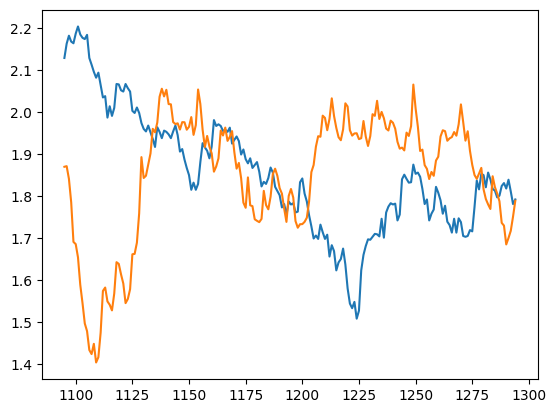

In [147]:
plt.plot(x[-200:], y1[-200:])
plt.plot(x[-200:], pd.Series(y2[-200:])*2)

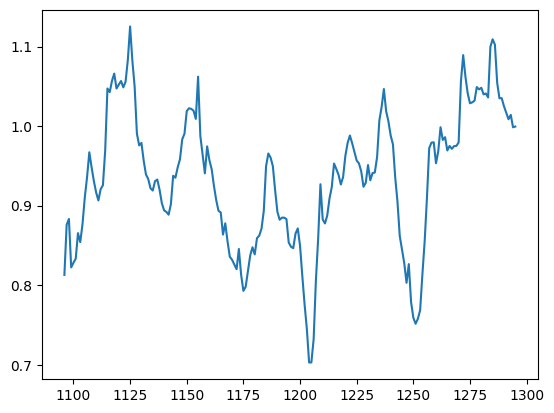

In [133]:
plt.plot(x[-200:], y2[-200:])

In [5]:

 
bond_cov_stock_issue_cninfo_df = ak.bond_cov_stock_issue_cninfo()
s_list = bond_cov_stock_issue_cninfo_df['标的股票'].tolist()


In [14]:
len(s_list)

308

In [2]:
realtime_dict

{'605366': {'name': '宏柏新材',
  'open': 6.82,
  'close': 6.8,
  'now': 6.9,
  'high': 6.95,
  'low': 6.75,
  'buy': 6.89,
  'sell': 6.9,
  'turnover': 1486452,
  'volume': 10239185.0,
  'bid1_volume': 8800,
  'bid1': 6.89,
  'bid2_volume': 98000,
  'bid2': 6.88,
  'bid3_volume': 8300,
  'bid3': 6.87,
  'bid4_volume': 12900,
  'bid4': 6.86,
  'bid5_volume': 27400,
  'bid5': 6.85,
  'ask1_volume': 6200,
  'ask1': 6.9,
  'ask2_volume': 2180,
  'ask2': 6.91,
  'ask3_volume': 74500,
  'ask3': 6.92,
  'ask4_volume': 46800,
  'ask4': 6.93,
  'ask5_volume': 49900,
  'ask5': 6.94,
  'date': '2024-05-29',
  'time': '10:36:18'},
 '603319': {'name': '湘油泵',
  'open': 18.0,
  'close': 17.18,
  'now': 17.56,
  'high': 18.0,
  'low': 17.45,
  'buy': 17.55,
  'sell': 17.56,
  'turnover': 2821786,
  'volume': 49776607.0,
  'bid1_volume': 7500,
  'bid1': 17.55,
  'bid2_volume': 1240,
  'bid2': 17.54,
  'bid3_volume': 3700,
  'bid3': 17.53,
  'bid4_volume': 5700,
  'bid4': 17.52,
  'bid5_volume': 5000,
  'b

In [4]:
6.9/6.8

1.0147058823529413

In [41]:
import akshare as ak
import easyquotation

quotation = easyquotation.use('sina')
result = {}
realtime_dict = quotation.stocks(s_list)
for ele in realtime_dict:
    close = realtime_dict[ele]["close"]
    now = realtime_dict[ele]["now"]
    name = realtime_dict[ele]["name"]
    rate = (now/close-1)*100
    
    if rate>=9.9:
        print(ele, name, rate)

603327 福蓉科技 10.020876826722347
688599 天合光能 9.990253411306039
300305 裕兴股份 20.062208398133752


In [34]:
import json
import re
import time

import requests

userAgent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.192 Safari/537.36"
header = {
    "Referer": "https://www.jisilu.cn/data/cbnew/",
    'User-Agent': userAgent,
    'Cookie': "kbzw__Session=5u6136maucteofr8hv36qpm9k7; kbz_newcookie=1; kbzw_r_uname=macrochen; kbzw__user_login=7Obd08_P1ebax9aX5MPZ0-ba293PkZyh6dbc7OPm1Nq_1KKq2sSkktnepaGrpKeZrpSsraqxlaeT2q_Wnd-l2MWsmJiyoO3K1L_RpKagrKWuk5ecpMy01r6bruPz3tXlzaaXpJGXn8DZxNnP6Ojo0bSMwNDqxuOXwNnEkLDHmc2JqpzWk6rAqKCTudHgzdnQ2svE1euRq5SupaaugZisvM3CtaWM48vhxpe-2NvM34qUvN3b6Nncka-RpaehrJWjkaKyqInMzd3D6MqmrKavj6OX; Hm_lvt_164fe01b1433a19b507595a43bf58262=1619880428,1620457500; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1620978364"
}


def get_content():
    # https://32.push2.eastmoney.com/api/qt/clist/get?cb=jQuery1124045700749086112435_1634389030530&pn=3&pz=100&po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&fid=f243&fs=b:MK0354&fields=f2,f3,f12,f14,f229,f230,f237&_=1634389030541
    url = "http://32.push2.eastmoney.com/api/qt/clist/get?cb=jQuery1124045700749086112435_" + str(int(round(time.time() * 1000))) + "&pn=1&pz=400&po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&fid=f243&fs=b:MK0354&fields=f2,f3,f12,f14,f229,f230,f237,f232&_=" + str(int(round(time.time() * 1000)))

    response = requests.get(url)
    code = response.status_code
    if code != 200:
        print("获取数据失败， 状态码：" + code)

    content = response.text

    return parse_content(content)


def parse_content(content):
    data = None
    try:
        data = json.loads(re.match(".*?({.*}).*", content, re.S).group(1))
    except:
        raise ValueError('Invalid Input')

    print("load data is successful")

    # 所有数据行
    rows = data['data']['diff']

    if len(rows) == 0:
        print("未获取到数据。")

    # if len(rows) == 30:
    #     # print("目前是游客身份，只能获取30条记录，请先登录")
    #     raise Exception("目前是游客身份，只能获取30条记录，请先登录")

    return rows

In [35]:
a = get_content()

load data is successful


In [38]:
s_list = list(set([ele['f232'] for ele in a]))

In [39]:
s_list

['688223',
 '688516',
 '000401',
 '601009',
 '300911',
 '603669',
 '002381',
 '605068',
 '300852',
 '603213',
 '603180',
 '002126',
 '300775',
 '300655',
 '600141',
 '300791',
 '300813',
 '603681',
 '300607',
 '300966',
 '603535',
 '603733',
 '002709',
 '300057',
 '002937',
 '002225',
 '688301',
 '002833',
 '688680',
 '300239',
 '002237',
 '600521',
 '300779',
 '300037',
 '000723',
 '300837',
 '300121',
 '300346',
 '603956',
 '300814',
 '300973',
 '002931',
 '601636',
 '603806',
 '603877',
 '688595',
 '601208',
 '688002',
 '300830',
 '002850',
 '300614',
 '300729',
 '300872',
 '601665',
 '002988',
 '301193',
 '603937',
 '002568',
 '300645',
 '000708',
 '002859',
 '301268',
 '002959',
 '603585',
 '002714',
 '600810',
 '300890',
 '688678',
 '002761',
 '603713',
 '003004',
 '688311',
 '002809',
 '601128',
 '301078',
 '002698',
 '002541',
 '002645',
 '300078',
 '603809',
 '300942',
 '603327',
 '603208',
 '300298',
 '300853',
 '605358',
 '301040',
 '603501',
 '300948',
 '603979',
 '300651',

In [6]:
len(a)

400

In [7]:

url = 'http://28.push2.eastmoney.com/api/qt/clist/get'
paras = {    'cb':'jQuery112408601316669762897_1636859793696',    'pn':'1',    'pz':'50',    'po':'1',    'np':'1',    'ut':'bd1d9ddb04089700cf9c27f6f7426281',    'fltt':'2',    'invt':'2',    'fid':'f243',    'fs':'b:MK0354',    'fields':'f1,f152,f2,f3,f12,f13,f14,f227,f228,f229,f230,f231,f232,f233,f234,f235,f236,f237,f238,f239,f240,f241,f242,f26,f243',    '_':'1636859793697'        }
headers = { 'User-Agent':'Mozilla/5.0 (Windows NT 6.1; ) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.129 Safari/537.36'        }
res = requests.get(url, paras, headers=headers)

In [10]:
result = res.text

In [11]:
result

'jQuery112408601316669762897_1636859793696({"rc":0,"rt":6,"svr":180606406,"lt":1,"full":1,"dlmkts":"","data":{"total":537,"diff":[{"f1":3,"f2":117.698,"f3":0.42,"f12":"111019","f13":1,"f14":"宏柏转债","f26":20240514,"f152":2,"f227":92.9291,"f228":6.8,"f229":6.91,"f230":1.62,"f231":2,"f232":"605366","f233":1,"f234":"宏柏新材","f235":7.51,"f236":92.0107,"f237":27.92,"f238":26.65,"f239":5.26,"f240":9.76,"f241":115.0,"f242":20241023,"f243":20240417},{"f1":3,"f2":128.502,"f3":0.06,"f12":"113684","f13":1,"f14":"湘泵转债","f26":20240429,"f152":2,"f227":91.5987,"f228":17.18,"f229":17.53,"f230":2.04,"f231":2,"f232":"603319","f233":1,"f234":"湘油泵","f235":16.99,"f236":103.1195,"f237":24.61,"f238":40.29,"f239":11.89,"f240":22.09,"f241":113.0,"f242":20241009,"f243":20240401},{"f1":3,"f2":235.611,"f3":-7.05,"f12":"113683","f13":1,"f14":"伟24转债","f26":20240422,"f152":2,"f227":97.2961,"f228":21.25,"f229":21.53,"f230":1.32,"f231":2,"f232":"603568","f233":1,"f234":"伟明环保","f235":18.28,"f236":117.779,"f237":100.05,"f23

In [12]:
data = json.loads(re.match(".*?({.*}).*", result, re.S).group(1))

In [16]:
data['data']

{'total': 537,
 'diff': [{'f1': 3,
   'f2': 117.698,
   'f3': 0.42,
   'f12': '111019',
   'f13': 1,
   'f14': '宏柏转债',
   'f26': 20240514,
   'f152': 2,
   'f227': 92.9291,
   'f228': 6.8,
   'f229': 6.91,
   'f230': 1.62,
   'f231': 2,
   'f232': '605366',
   'f233': 1,
   'f234': '宏柏新材',
   'f235': 7.51,
   'f236': 92.0107,
   'f237': 27.92,
   'f238': 26.65,
   'f239': 5.26,
   'f240': 9.76,
   'f241': 115.0,
   'f242': 20241023,
   'f243': 20240417},
  {'f1': 3,
   'f2': 128.502,
   'f3': 0.06,
   'f12': '113684',
   'f13': 1,
   'f14': '湘泵转债',
   'f26': 20240429,
   'f152': 2,
   'f227': 91.5987,
   'f228': 17.18,
   'f229': 17.53,
   'f230': 2.04,
   'f231': 2,
   'f232': '603319',
   'f233': 1,
   'f234': '湘油泵',
   'f235': 16.99,
   'f236': 103.1195,
   'f237': 24.61,
   'f238': 40.29,
   'f239': 11.89,
   'f240': 22.09,
   'f241': 113.0,
   'f242': 20241009,
   'f243': 20240401},
  {'f1': 3,
   'f2': 235.611,
   'f3': -7.05,
   'f12': '113683',
   'f13': 1,
   'f14': '伟24转债',
 

In [17]:
s_slit = [ele['f232'] for ele in data['data']['diff']]

In [18]:
s_slit

['605366',
 '603319',
 '603568',
 '603939',
 '002442',
 '300358',
 '002605',
 '300488',
 '300863',
 '300793',
 '002135',
 '603213',
 '002761',
 '605077',
 '001283',
 '301193',
 '601137',
 '000034',
 '300911',
 '688076',
 '300062',
 '001205',
 '301069',
 '300830',
 '001269',
 '603937',
 '300938',
 '301133',
 '001317',
 '603105',
 '003036',
 '301062',
 '300953',
 '301099',
 '603220',
 '002111',
 '002809',
 '002598',
 '300814',
 '300890',
 '001288',
 '301266',
 '300705',
 '603306',
 '688311',
 '688398',
 '300926',
 '002335',
 '301188',
 '300942']

In [42]:
import easyquotation
import json
import re
import time

import requests
quotation = easyquotation.use('sina')
userAgent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.192 Safari/537.36"
header = {
    "Referer": "https://www.jisilu.cn/data/cbnew/",
    'User-Agent': userAgent,
    'Cookie': "kbzw__Session=5u6136maucteofr8hv36qpm9k7; kbz_newcookie=1; kbzw_r_uname=macrochen; kbzw__user_login=7Obd08_P1ebax9aX5MPZ0-ba293PkZyh6dbc7OPm1Nq_1KKq2sSkktnepaGrpKeZrpSsraqxlaeT2q_Wnd-l2MWsmJiyoO3K1L_RpKagrKWuk5ecpMy01r6bruPz3tXlzaaXpJGXn8DZxNnP6Ojo0bSMwNDqxuOXwNnEkLDHmc2JqpzWk6rAqKCTudHgzdnQ2svE1euRq5SupaaugZisvM3CtaWM48vhxpe-2NvM34qUvN3b6Nncka-RpaehrJWjkaKyqInMzd3D6MqmrKavj6OX; Hm_lvt_164fe01b1433a19b507595a43bf58262=1619880428,1620457500; Hm_lpvt_164fe01b1433a19b507595a43bf58262=1620978364"
}


def check_stock_board(code):
    """
    判断股票代码是否属于科创板或创业板。
    """
    if code.startswith('688'):
        return False
    elif code.startswith('300'):
        return False
    else:
        return True

def get_content():
    # https://32.push2.eastmoney.com/api/qt/clist/get?cb=jQuery1124045700749086112435_1634389030530&pn=3&pz=100&po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&fid=f243&fs=b:MK0354&fields=f2,f3,f12,f14,f229,f230,f237&_=1634389030541
    url = "http://32.push2.eastmoney.com/api/qt/clist/get?cb=jQuery1124045700749086112435_" + str(int(round(time.time() * 1000))) + "&pn=1&pz=400&po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&fid=f243&fs=b:MK0354&fields=f2,f3,f12,f14,f229,f230,f237,f232&_=" + str(int(round(time.time() * 1000)))

    response = requests.get(url)
    code = response.status_code
    if code != 200:
        print("获取数据失败， 状态码：" + code)

    content = response.text

    return parse_content(content)


def parse_content(content):
    data = None
    try:
        data = json.loads(re.match(".*?({.*}).*", content, re.S).group(1))
    except:
        raise ValueError('Invalid Input')

    # 所有数据行
    rows = data['data']['diff']

    if len(rows) == 0:
        print("未获取到数据。")
    return rows


content = get_content()
s_list = list(set([ele['f232'] for ele in content]))
result = {}
realtime_dict = quotation.stocks(s_list)
for ele in realtime_dict:
    close = realtime_dict[ele]["close"]
    now = realtime_dict[ele]["now"]
    name = realtime_dict[ele]["name"]
    rate = (now/close-1)*100
    
    if check_stock_board(ele) and rate>=9.9:
        print(ele, name, rate)
    if not check_stock_board(ele) and rate>=19.9:
        print(ele, name, rate)

603327 福蓉科技 10.020876826722347
300305 裕兴股份 20.062208398133752


In [2]:
import optuna
import pandas as pd
import numpy as np
import warnings
import empyrical
warnings.filterwarnings(action="ignore")
df = pd.read_parquet("etf.parquet")

df = df.drop_duplicates(subset=["code", "date"])
df = df.sort_values(by="date")
df = df[df.code=="510050"]
# df = df[:-1000]

def softmax(x):
    """Softmax激活函数，用于输出层"""
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

# Define an objective function to be minimized.
def objective():
    n_row = 20
    n_col = 3
    low = -1
    high = 1
    p_dict = {'0_0': 0.880279463629757, '0_1': 0.7090390358894242, '0_2': -0.2859520538805025, '1_0': 0.9974446783926126, '1_1': -0.7587497565284482, '1_2': -0.36695968947877056, '2_0': 0.06460068245414824, '2_1': 0.5513543385288495, '2_2': -0.7303754701128025, '3_0': 0.37569221965158567, '3_1': 0.027825256514880492, '3_2': -0.0011195745429460162, '4_0': 0.3885669202859921, '4_1': -0.20403674538904482, '4_2': 0.22584705795316162, '5_0': 0.40800574889407415, '5_1': -0.22035571125468384, '5_2': -0.8119589027986907, '6_0': 0.3043939306028106, '6_1': 0.7987311187997774, '6_2': 0.10971901989893254, '7_0': -0.2939049792991183, '7_1': -0.7449480921154255, '7_2': -0.5380381772289307, '8_0': -0.21964913482222256, '8_1': -0.7733689029845052, '8_2': 0.32842503598239636, '9_0': -0.7999498282827735, '9_1': 0.8608058239815652, '9_2': -0.20535681120908733, '10_0': 0.2971114381246166, '10_1': 0.8269124238351231, '10_2': 0.9137742486182691, '11_0': -0.710389256091359, '11_1': 0.5813046980009269, '11_2': 0.04466204830612855, '12_0': -0.5520678773508552, '12_1': 0.13907932404942702, '12_2': -0.5722779214119966, '13_0': 0.61076684583401, '13_1': 0.38874690731316064, '13_2': -0.5335324841173611, '14_0': -0.8899248661656358, '14_1': -0.09081006513847306, '14_2': -0.3224675376793342, '15_0': 0.14795073597171549, '15_1': -0.8006882538641082, '15_2': -0.9491500282061285, '16_0': 0.9945813373642708, '16_1': 0.326176481782539, '16_2': -0.6389233096960242, '17_0': 0.30147809813161325, '17_1': 0.7752202369978474, '17_2': -0.34979796343964104, '18_0': 0.6685020157975131, '18_1': 0.4772495744337424, '18_2': -0.0463179080989127, '19_0': -0.8345761330865932, '19_1': -0.723720496515091, '19_2': 0.37892657800064383, 'b': 0.0030770551579609754}
    parameters = np.zeros(shape=(n_row, n_col))
    for i in range(n_row):
        for j in range(n_col):
            # parameters[i][j] = trial.suggest_float(f"{i}_{j}", low, high)
            parameters[i][j] = p_dict[f"{i}_{j}"]
    # b = trial.suggest_float("b", low, high)
    b = p_dict["b"]
            
    def get_action(ts):
        input_array = np.array(ts.tolist()).reshape(1, -1)
        output = softmax(np.dot(input_array, parameters)+b)
        action = np.argmax(output, axis=-1)
        action = action[0]
        assert action in (0, 1, 2)
        return action
    
    sharpe = get_profit(get_action, n_row)
    return -sharpe

def get_profit(get_action, window):
    df["is_buy"] = df.close.rolling(window).apply(get_action)    
    max_len = len(df)
    close_array = df["close"].tolist()
    is_buy_array = df["is_buy"].tolist()
    dates = df["date"].tolist()
    profit = 1
    last_status = 0
    profits = []
    
    for i in range(window, max_len):
        all_is_buy = is_buy_array[i]
        last_price = close_array[i-1]
        current_price = close_array[i]
        profit = profit*(current_price/last_price) if last_status else profit
        if all_is_buy==1:
            last_status = 1
        elif all_is_buy==0:
            last_status = 0
        else:
            last_status = last_status
        profits.append([dates[i], profit, last_status])
    df_profits = pd.DataFrame(profits)
    df_profits.index = df_profits[0]
    df_profits.to_csv("temp.csv")
    sharpe = empyrical.sharpe_ratio(df_profits[1])
    if np.isnan(sharpe) or np.isinf(sharpe):
        sharpe = 0
    return sharpe

sharpe = objective()

FileNotFoundError: [Errno 2] No such file or directory: 'etf.parquet'

In [ ]:
sharpe